## Install dependencies

In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys

!{sys.executable} -m pip install smdebug
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install bokeh
!{sys.executable} -m pip install imageio

In [4]:
pip install mxnet

Note: you may need to restart the kernel to use updated packages.


## Import the relevant libraries into our Amazon SageMaker notebook

In [5]:
import os
import boto3
import io
import sagemaker

%matplotlib inline

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.style.use("ggplot")
import pickle, gzip, urllib, json
import csv

In [6]:
from sagemaker import get_execution_role

role = get_execution_role()

In [7]:
role

'arn:aws:iam::516423377310:role/service-role/AmazonSageMaker-ExecutionRole-20220823T141263'

## Loading the data from Amazon S3

In [86]:
country_data = pd.read_csv('s3://aws-workshop-ml-datasets/Datasets/country_2022_new.csv')

In [87]:
country_data

,iso_code,Country,date,total_cases,total_deaths,total_cases_per_million,total_cases_per_hundred,total_deaths_per_million,total_deaths_per_hundred,total_vaccinations,total_vaccinations_per_hundred,population 2022
0,ATG,Antigua and Barbuda,5/30/2022,8163,138.0,87567.046,8.757,1480.369,0.148,125877,135.03,93220
1,ARG,Argentina,5/30/2022,9230573,128889.0,203869.909,20.387,2846.691,0.285,103197137,227.93,45276780
2,ABW,Aruba,5/30/2022,37034,213.0,347619.584,34.762,1999.324,0.200,171109,160.61,106536
3,AUS,Australia,5/30/2022,7276695,8525.0,280724.895,28.072,328.883,0.033,57629386,222.33,25921089
4,BHR,Bahrain,5/30/2022,585082,1488.0,399846.918,39.985,1016.904,0.102,3444526,235.40,1463265
...,...,...,...,...,...,...,...,...,...,...,...,...
64,TUR,Turkey,5/30/2022,15071772,98961.0,177784.726,17.778,1167.332,0.117,147728185,174.26,84775404
65,GBR,United Kingdom,5/30/2022,22370976,178725.0,332500.449,33.250,2656.395,0.266,148489319,220.70,67281040
66,USA,United States,5/30/2022,84127770,1006838.0,249639.060,24.964,2987.671,0.299,588976658,177.40,336997624
67,URY,Uruguay,5/30/2022,916388,7227.0,267460.146,26.746,2109.297,0.211,8395509,245.03,3426260


In [88]:
country_data.head()

,iso_code,Country,date,total_cases,total_deaths,total_cases_per_million,total_cases_per_hundred,total_deaths_per_million,total_deaths_per_hundred,total_vaccinations,total_vaccinations_per_hundred,population 2022
0,ATG,Antigua and Barbuda,5/30/2022,8163,138.0,87567.046,8.757,1480.369,0.148,125877,135.03,93220
1,ARG,Argentina,5/30/2022,9230573,128889.0,203869.909,20.387,2846.691,0.285,103197137,227.93,45276780
2,ABW,Aruba,5/30/2022,37034,213.0,347619.584,34.762,1999.324,0.200,171109,160.61,106536
3,AUS,Australia,5/30/2022,7276695,8525.0,280724.895,28.072,328.883,0.033,57629386,222.33,25921089
4,BHR,Bahrain,5/30/2022,585082,1488.0,399846.918,39.985,1016.904,0.102,3444526,235.40,1463265


In [89]:
country_data.shape

(69, 12)

In [90]:
# drop incomplete columns
country_data_2022 = country_data.dropna()

In [91]:
country_data_2022.shape

(68, 12)

In [97]:
country_data_2022 = country_data_2022.drop(columns=['total_cases','total_deaths','total_cases_per_million','total_deaths_per_million','total_vaccinations','population 2022'])

In [98]:
country_data_2022.head()

,iso_code,Country,date,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
0,ATG,Antigua and Barbuda,5/30/2022,8.757,0.148,135.03
1,ARG,Argentina,5/30/2022,20.387,0.285,227.93
2,ABW,Aruba,5/30/2022,34.762,0.200,160.61
3,AUS,Australia,5/30/2022,28.072,0.033,222.33
4,BHR,Bahrain,5/30/2022,39.985,0.102,235.40


In [99]:
country_data_2022.columns = ["Code","Country", "Date","total_cases_per_hundred","total_deaths_per_hundred","total_vaccinations_per_hundred"]

In [100]:
country_data_2022.head()

,Code,Country,Date,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
0,ATG,Antigua and Barbuda,5/30/2022,8.757,0.148,135.03
1,ARG,Argentina,5/30/2022,20.387,0.285,227.93
2,ABW,Aruba,5/30/2022,34.762,0.200,160.61
3,AUS,Australia,5/30/2022,28.072,0.033,222.33
4,BHR,Bahrain,5/30/2022,39.985,0.102,235.40


In [101]:
gdp_data = pd.read_csv('s3://aws-workshop-ml-datasets/Datasets/gdp_data.csv')

In [102]:
gdp_data.columns = ["Code","Country","Day","GDP_per_capita"]

## Combine GDP with cases

In [103]:
country_gdp_data_2022 = gdp_data.merge(country_data_2022, on="Code", how='left')

In [104]:
country_gdp_data_2022.head()

,Code,Country_x,Day,GDP_per_capita,Country_y,Date,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
0,AFG,Afghanistan,5/30/2022,1803.987,NaN,NaN,NaN,NaN,NaN
1,ALB,Albania,5/30/2022,11803.431,NaN,NaN,NaN,NaN,NaN
2,DZA,Algeria,5/30/2022,13913.839,NaN,NaN,NaN,NaN,NaN
3,AGO,Angola,5/30/2022,5819.495,NaN,NaN,NaN,NaN,NaN
4,ATG,Antigua and Barbuda,5/30/2022,21490.943,Antigua and Barbuda,5/30/2022,8.757,0.148,135.03


In [107]:
country_gdp_data_2022 = country_gdp_data_2022.dropna()

In [108]:
country_gdp_data_2022.head()

,Code,Country_x,Day,GDP_per_capita,Country_y,Date,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
4,ATG,Antigua and Barbuda,5/30/2022,21490.943,Antigua and Barbuda,5/30/2022,8.757,0.148,135.03
5,ARG,Argentina,5/30/2022,18933.907,Argentina,5/30/2022,20.387,0.285,227.93
7,ABW,Aruba,5/30/2022,35973.781,Aruba,5/30/2022,34.762,0.200,160.61
8,AUS,Australia,5/30/2022,44648.710,Australia,5/30/2022,28.072,0.033,222.33
12,BHR,Bahrain,5/30/2022,43290.705,Bahrain,5/30/2022,39.985,0.102,235.40


In [109]:
country_gdp_data_2022 =country_gdp_data_2022.drop(columns =["Country_y","Date"])

In [110]:
country_gdp_data_2022.head()

,Code,Country_x,Day,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
4,ATG,Antigua and Barbuda,5/30/2022,21490.943,8.757,0.148,135.03
5,ARG,Argentina,5/30/2022,18933.907,20.387,0.285,227.93
7,ABW,Aruba,5/30/2022,35973.781,34.762,0.200,160.61
8,AUS,Australia,5/30/2022,44648.710,28.072,0.033,222.33
12,BHR,Bahrain,5/30/2022,43290.705,39.985,0.102,235.40


In [111]:
country_gdp_data_2022.columns = ["Code","Country","Date","GDP_per_capita","total_cases_per_hundred","total_deaths_per_hundred","total_vaccinations_per_hundred"]

In [112]:
country_gdp_data_2022

,Code,Country,Date,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
4,ATG,Antigua and Barbuda,5/30/2022,21490.943,8.757,0.148,135.03
5,ARG,Argentina,5/30/2022,18933.907,20.387,0.285,227.93
7,ABW,Aruba,5/30/2022,35973.781,34.762,0.200,160.61
8,AUS,Australia,5/30/2022,44648.710,28.072,0.033,222.33
12,BHR,Bahrain,5/30/2022,43290.705,39.985,0.102,235.40
...,...,...,...,...,...,...,...
179,TUR,Turkey,5/30/2022,25129.341,17.778,0.117,174.26
183,GBR,United Kingdom,5/30/2022,39753.244,33.250,0.266,220.70
184,USA,United States,5/30/2022,54225.446,24.964,0.299,177.40
185,URY,Uruguay,5/30/2022,20551.409,26.746,0.211,245.03


## Restrictions Data Input

In [50]:
#restrictions_df = pd.read_csv('s3://aws-workshop-ml-datasets/Datasets_preprocessed/output_1662640992/masterdataset_restriction.csv')

## Select May. 30 as a snapshot

In [52]:
# restrictions_data_2022 = restrictions_df[restrictions_df['Day'].isin(['2022-05-30'])]

In [53]:
# restrictions_data_2022.head()

,Code,Day,facial_coverings,cancel_public_events,stay_home_requirements,school_closures
860,AFG,2022-05-30,3,1,0,0
1768,ALB,2022-05-30,2,0,0,0
2669,DZA,2022-05-30,3,1,0,1
3579,AND,2022-05-30,0,0,0,0
4460,AGO,2022-05-30,3,1,1,0


## Set indexes for the dataset

In [114]:
country_gdp_data_2022.index = country_gdp_data_2022["Code"] + "-" + country_gdp_data_2022["Country"] + "-" + country_gdp_data_2022["Date"]
country_gdp_data_2022.head()
drop = ["Code", "Country", "Date"]
country_gdp_data_2022.drop(drop, axis=1, inplace=True)
#country_data.drop(drop, axis=1, inplace=False)
country_gdp_data_2022.head()

,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
ATG-Antigua and Barbuda-5/30/2022,21490.943,8.757,0.148,135.03
ARG-Argentina-5/30/2022,18933.907,20.387,0.285,227.93
ABW-Aruba-5/30/2022,35973.781,34.762,0.200,160.61
AUS-Australia-5/30/2022,44648.710,28.072,0.033,222.33
BHR-Bahrain-5/30/2022,43290.705,39.985,0.102,235.40


## Feature engineering

#### Data scaling using MinMaxScaler

In [115]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
country_data_scaled = pd.DataFrame(scaler.fit_transform(country_gdp_data_2022))
country_data_scaled.columns = country_gdp_data_2022.columns
country_data_scaled.index =country_gdp_data_2022.index

In [116]:
country_data_scaled.describe()

,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
count,64.000000,64.000000,64.000000,64.000000
mean,0.234547,0.379752,0.270644,0.563670
std,0.196084,0.280790,0.215612,0.224684
min,0.000000,0.000000,0.000000,0.000000
25%,0.090238,0.128502,0.073972,0.436696
50%,0.191627,0.332851,0.242880,0.580460
75%,0.319944,0.616854,0.435127,0.746885
max,1.000000,1.000000,1.000000,1.000000


In [117]:
country_data_scaled

,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
ATG-Antigua and Barbuda-5/30/2022,0.170305,0.162496,0.234177,0.430493
ARG-Argentina-5/30/2022,0.148077,0.379843,0.450949,0.771962
ABW-Aruba-5/30/2022,0.296203,0.648489,0.316456,0.524517
AUS-Australia-5/30/2022,0.371614,0.523463,0.052215,0.751378
BHR-Bahrain-5/30/2022,0.359809,0.746099,0.161392,0.799419
...,...,...,...,...
TUR-Turkey-5/30/2022,0.201933,0.331084,0.185127,0.574689
GBR-United Kingdom-5/30/2022,0.329058,0.620232,0.420886,0.745387
USA-United States-5/30/2022,0.454864,0.465380,0.473101,0.586231
URY-Uruguay-5/30/2022,0.162138,0.498682,0.333861,0.834816


In [118]:
train_data = country_data_scaled.values.astype("float32")

In [119]:
train_data

array([[0.17030492, 0.16249603, 0.23417722, 0.43049327],
       [0.14807676, 0.37984264, 0.45094937, 0.77196205],
       [0.29620343, 0.64848906, 0.3164557 , 0.52451664],
       [0.3716141 , 0.52346337, 0.05221519, 0.75137836],
       [0.35980904, 0.7460988 , 0.1613924 , 0.7994192 ],
       [0.13107476, 0.53267676, 0.25158226, 0.34617364],
       [0.35431397, 0.66719615, 0.431962  , 0.7379622 ],
       [0.04334349, 0.13945317, 0.2879747 , 0.350952  ],
       [0.10608588, 0.2689641 , 0.49208862, 0.6902889 ],
       [0.14485516, 0.31501243, 0.8528481 , 0.16897008],
       [0.36612782, 0.18899624, 0.1693038 , 0.7573697 ],
       [0.18139794, 0.35343587, 0.4699367 , 1.        ],
       [0.11656314, 0.        , 0.        , 0.80552083],
       [0.18055265, 0.5219496 , 0.62341774, 0.4097258 ],
       [0.26692668, 0.6958269 , 0.60601264, 0.5509446 ],
       [0.38929385, 1.        , 0.17246835, 0.76225835],
       [0.11040983, 0.09695565, 0.06170886, 0.45203263],
       [0.07547354, 0.09095666,

## Population segmentation using unsupervised clustering K-Means

## Import & train the K-Means Algo

In [120]:
from sagemaker import KMeans

num_clusters = 3
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path= 's3://aws-workshop-ml-datasets/clustering_output',
    k=num_clusters
)

## Train the model

In [121]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-09-08 14:54:19 Starting - Starting the training job...
2022-09-08 14:54:42 Starting - Preparing the instances for trainingProfilerReport-1662648859: InProgress
......
2022-09-08 14:55:46 Downloading - Downloading input data...
2022-09-08 14:56:11 Training - Downloading the training image.........
2022-09-08 14:57:43 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/08/2022 14:57:40 INFO 140417070446400] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_p

In [ ]:
## Deploy the model

In [122]:
%%time
#kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.t3.medium")
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.c4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!CPU times: user 184 ms, sys: 7.33 ms, total: 191 ms
Wall time: 5min 1s


In [123]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 137 ms


In [124]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [125]:
pd.DataFrame(cluster_labels)[0].value_counts()

1.0    24
0.0    23
2.0    17
Name: 0, dtype: int64

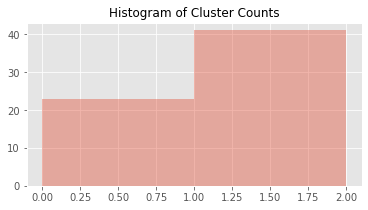

In [126]:
ax = plt.subplots(figsize=(6, 3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [127]:
job_name = kmeans.latest_training_job.name
model_key = "clustering_output/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket("aws-workshop-ml-datasets").download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

In [128]:
job_name = kmeans.latest_training_job.name

In [129]:
job_name

'kmeans-2022-09-08-14-54-19-379'

In [130]:
model_key

'clustering_output/kmeans-2022-09-08-14-54-19-379/output/model.tar.gz'

In [131]:
Kmeans_model_params = mx.ndarray.load("model_algo-1")

In [132]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = country_data_scaled.columns

In [133]:
cluster_centroids

,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred
0,0.071385,0.093382,0.139060,0.405952
1,0.387864,0.527501,0.218776,0.779021
2,0.217807,0.547696,0.527990,0.501554


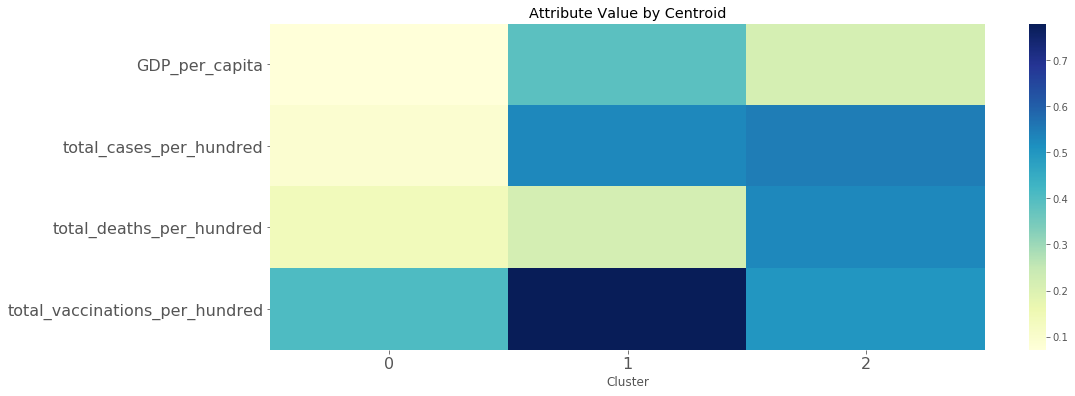

In [134]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap="YlGnBu")
ax.set_xlabel("Cluster")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [135]:
country_data_scaled["labels"] = list(map(int, cluster_labels))
country_data_scaled.head()

,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred,labels
ATG-Antigua and Barbuda-5/30/2022,0.170305,0.162496,0.234177,0.430493,0
ARG-Argentina-5/30/2022,0.148077,0.379843,0.450949,0.771962,2
ABW-Aruba-5/30/2022,0.296203,0.648489,0.316456,0.524517,2
AUS-Australia-5/30/2022,0.371614,0.523463,0.052215,0.751378,1
BHR-Bahrain-5/30/2022,0.359809,0.746099,0.161392,0.799419,1


In [136]:
country_data_scaled

,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred,labels
ATG-Antigua and Barbuda-5/30/2022,0.170305,0.162496,0.234177,0.430493,0
ARG-Argentina-5/30/2022,0.148077,0.379843,0.450949,0.771962,2
ABW-Aruba-5/30/2022,0.296203,0.648489,0.316456,0.524517,2
AUS-Australia-5/30/2022,0.371614,0.523463,0.052215,0.751378,1
BHR-Bahrain-5/30/2022,0.359809,0.746099,0.161392,0.799419,1
...,...,...,...,...,...
TUR-Turkey-5/30/2022,0.201933,0.331084,0.185127,0.574689,0
GBR-United Kingdom-5/30/2022,0.329058,0.620232,0.420886,0.745387,1
USA-United States-5/30/2022,0.454864,0.465380,0.473101,0.586231,2
URY-Uruguay-5/30/2022,0.162138,0.498682,0.333861,0.834816,1


In [137]:
type(country_data_scaled)

pandas.core.frame.DataFrame

In [138]:
country_data_scaled.index

Index(['ATG-Antigua and Barbuda-5/30/2022', 'ARG-Argentina-5/30/2022',
       'ABW-Aruba-5/30/2022', 'AUS-Australia-5/30/2022',
       'BHR-Bahrain-5/30/2022', 'BRB-Barbados-5/30/2022',
       'BEL-Belgium-5/30/2022', 'BOL-Bolivia-5/30/2022',
       'BRA-Brazil-5/30/2022', 'BGR-Bulgaria-5/30/2022',
       'CAN-Canada-5/30/2022', 'CHL-Chile-5/30/2022', 'CHN-China-5/30/2022',
       'HRV-Croatia-5/30/2022', 'CZE-Czechia-5/30/2022',
       'DNK-Denmark-5/30/2022', 'DOM-Dominican Republic-5/30/2022',
       'ECU-Ecuador-5/30/2022', 'EGY-Egypt-5/30/2022',
       'SLV-El Salvador-5/30/2022', 'EST-Estonia-5/30/2022',
       'FJI-Fiji-5/30/2022', 'FRA-France-5/30/2022', 'DEU-Germany-5/30/2022',
       'GRC-Greece-5/30/2022', 'HKG-Hong Kong-5/30/2022',
       'IND-India-5/30/2022', 'IDN-Indonesia-5/30/2022', 'IRN-Iran-5/30/2022',
       'IRL-Ireland-5/30/2022', 'ISR-Israel-5/30/2022', 'ITA-Italy-5/30/2022',
       'JAM-Jamaica-5/30/2022', 'JPN-Japan-5/30/2022',
       'KGZ-Kyrgyzstan-5/30/2022'

In [ ]:
#country_data_scaled["Country_code"]=country_data_scaled.index.to_().str.split("-").str[:1]

In [143]:
country_data_scaled

,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred,labels
ATG-Antigua and Barbuda-5/30/2022,0.170305,0.162496,0.234177,0.430493,0
ARG-Argentina-5/30/2022,0.148077,0.379843,0.450949,0.771962,2
ABW-Aruba-5/30/2022,0.296203,0.648489,0.316456,0.524517,2
AUS-Australia-5/30/2022,0.371614,0.523463,0.052215,0.751378,1
BHR-Bahrain-5/30/2022,0.359809,0.746099,0.161392,0.799419,1
...,...,...,...,...,...
TUR-Turkey-5/30/2022,0.201933,0.331084,0.185127,0.574689,0
GBR-United Kingdom-5/30/2022,0.329058,0.620232,0.420886,0.745387,1
USA-United States-5/30/2022,0.454864,0.465380,0.473101,0.586231,2
URY-Uruguay-5/30/2022,0.162138,0.498682,0.333861,0.834816,1


In [150]:
country_data_scaled = country_data_scaled.reset_index()

In [151]:
country_data_scaled

,index,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred,labels
0,ATG-Antigua and Barbuda-5/30/2022,0.170305,0.162496,0.234177,0.430493,0
1,ARG-Argentina-5/30/2022,0.148077,0.379843,0.450949,0.771962,2
2,ABW-Aruba-5/30/2022,0.296203,0.648489,0.316456,0.524517,2
3,AUS-Australia-5/30/2022,0.371614,0.523463,0.052215,0.751378,1
4,BHR-Bahrain-5/30/2022,0.359809,0.746099,0.161392,0.799419,1
...,...,...,...,...,...,...
59,TUR-Turkey-5/30/2022,0.201933,0.331084,0.185127,0.574689,0
60,GBR-United Kingdom-5/30/2022,0.329058,0.620232,0.420886,0.745387,1
61,USA-United States-5/30/2022,0.454864,0.465380,0.473101,0.586231,2
62,URY-Uruguay-5/30/2022,0.162138,0.498682,0.333861,0.834816,1


In [152]:
country_data_scaled_new=country_data_scaled['index'].str.split('-', expand=True)

In [153]:
country_data_scaled_new

,0,1,2
0,ATG,Antigua and Barbuda,5/30/2022
1,ARG,Argentina,5/30/2022
2,ABW,Aruba,5/30/2022
3,AUS,Australia,5/30/2022
4,BHR,Bahrain,5/30/2022
...,...,...,...
59,TUR,Turkey,5/30/2022
60,GBR,United Kingdom,5/30/2022
61,USA,United States,5/30/2022
62,URY,Uruguay,5/30/2022


In [ ]:
#country_data_scaled

In [ ]:
country_data_scaled_new

In [157]:
result=pd.concat([country_data_scaled_new,country_data_scaled], axis=1)

In [158]:
result

,0,1,2,index,GDP_per_capita,total_cases_per_hundred,total_deaths_per_hundred,total_vaccinations_per_hundred,labels
0,ATG,Antigua and Barbuda,5/30/2022,ATG-Antigua and Barbuda-5/30/2022,0.170305,0.162496,0.234177,0.430493,0
1,ARG,Argentina,5/30/2022,ARG-Argentina-5/30/2022,0.148077,0.379843,0.450949,0.771962,2
2,ABW,Aruba,5/30/2022,ABW-Aruba-5/30/2022,0.296203,0.648489,0.316456,0.524517,2
3,AUS,Australia,5/30/2022,AUS-Australia-5/30/2022,0.371614,0.523463,0.052215,0.751378,1
4,BHR,Bahrain,5/30/2022,BHR-Bahrain-5/30/2022,0.359809,0.746099,0.161392,0.799419,1
...,...,...,...,...,...,...,...,...,...
59,TUR,Turkey,5/30/2022,TUR-Turkey-5/30/2022,0.201933,0.331084,0.185127,0.574689,0
60,GBR,United Kingdom,5/30/2022,GBR-United Kingdom-5/30/2022,0.329058,0.620232,0.420886,0.745387,1
61,USA,United States,5/30/2022,USA-United States-5/30/2022,0.454864,0.465380,0.473101,0.586231,2
62,URY,Uruguay,5/30/2022,URY-Uruguay-5/30/2022,0.162138,0.498682,0.333861,0.834816,1


In [160]:
result.columns = ["Code","Country","Date","index","GDP_per_capita","total_cases_per_hundred","total_deaths_per_hundred","total_vaccinations_per_hundred","labels"]

In [162]:
result.to_csv('s3://aws-workshop-ml-datasets/output/masterdataset_gpd_output.csv')